## Import Libraries

In [1]:
import os
from pathlib import Path

# Data processing
import numpy as np
import pandas as pd
import io
import geopandas as gpd
import json

from datetime import datetime
from datetime import timedelta

# Data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set_style("white")
import plotly.graph_objects as go
import plotly.express as px

# Additional resources
import iso3166
from iso3166 import countries, countries_by_name # ISO data for countries
import world_bank_data as wb # World Bank Data for population data

/Users/reginagalambos/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
notebook_path = os.path.abspath("Notebook.ipynb")
project_path = Path(notebook_path).parent.parent

data_path = os.path.join(project_path, 'data')
external_data_path = os.path.join(data_path, 'external', '')
processed_data_path = os.path.join(data_path, 'processed', '')

In [3]:
# Get data from store
%store -r d

In [4]:
# Import COVID Dataset
covid_df = pd.read_csv(os.path.join(processed_data_path, 'covid_countries.csv'))

In [5]:
select_countries = ['CHN', 'FRA', 'GBR', 'ITA', 'KOR', 'USA']

In [6]:
shapefile = os.path.join(external_data_path, 'ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')

In [7]:
#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]

In [8]:
#Rename columns.
gdf.columns = ['country', 'country_code', 'geometry']
gdf.head()

,country,country_code,geometry
0,Indonesia,IDN,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Malaysia,MYS,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
2,Chile,CHL,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."
3,Bolivia,BOL,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5..."
4,Peru,PER,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832..."


In [364]:
print(gdf[gdf['country'] == 'Antarctica'])

#Drop row corresponding to 'Antarctica'
gdf = gdf.drop(gdf.index[172])

        country country_code  \
172  Antarctica          ATA   

                                              geometry  
172  MULTIPOLYGON (((-51.73064 -82.06256, -51.24690...  


In [9]:
covid_df.columns

Index(['Country', 'DisplayName', 'Latitude', 'Longitude', 'ISO2Code',
       'ISO3Code', 'ISONumCode', 'TotalPopulation', 'Continent', 'Date',
       'CaseType', 'DailyReportedCases', 'CumulativeReportedCases',
       'DailyReportedCasesPer100K', 'CumulativeReportedCasesPer100K',
       'GrowthFactor', 'GF_RollingGeomMean', 'DoublingTime'],
      dtype='object')

In [10]:
df = covid_df[['DisplayName', 'ISO3Code', 'Date', 'CaseType', 'DailyReportedCasesPer100K', 
          'CumulativeReportedCasesPer100K', 'GF_RollingGeomMean', 'DoublingTime']]

In [14]:
df = df[(df['ISO3Code'] == 'CHN') | 
         (df['ISO3Code'] == 'FRA') |
         (df['ISO3Code'] == 'GBR') |
         (df['ISO3Code'] == 'ITA') |
         (df['ISO3Code'] == 'KOR') |
         (df['ISO3Code'] == 'USA')]

In [17]:
df = df[df['CaseType'] == 'confirmed']

In [18]:
df.head()

,DisplayName,ISO3Code,Date,CaseType,DailyReportedCasesPer100K,CumulativeReportedCasesPer100K,GF_RollingGeomMean,DoublingTime
4080,China,CHN,2020-01-22,confirmed,0.038385,0.038385,0.0,-0.0
4081,China,CHN,2020-01-23,confirmed,0.006654,0.045039,0.0,-0.0
4082,China,CHN,2020-01-24,confirmed,0.019403,0.064442,0.0,-0.0
4083,China,CHN,2020-01-25,confirmed,0.034042,0.098484,0.0,-0.0
4084,China,CHN,2020-01-26,confirmed,0.046860,0.145344,0.0,-0.0


In [20]:
#Merge dataframes gdf and df_2016.
merged = gdf.merge(df, left_on = 'country_code', right_on = 'ISO3Code')

In [22]:
#Filter data for year 2016.
df_20200122 = merged[merged['Date'] == '2020-01-22']
df_20200415 = merged[merged['Date'] == '2020-04-15']

In [24]:
import json#Read data to json.
merged_start_json = json.loads(df_20200122.to_json())

#Convert to String like object.
json_data_start = json.dumps(merged_start_json)

In [25]:
merged_end_json = json.loads(df_20200415.to_json())

#Convert to String like object.
json_data_end = json.dumps(merged_end_json)

In [26]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer

In [41]:
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data_end)

In [28]:
#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][8]

In [29]:
#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]

In [30]:
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 40)

In [31]:
#Define custom tick labels for color bar.
tick_labels = {'0': '0%', '5': '5%', '10':'10%', '15':'15%', '20':'20%', '25':'25%', '30':'30%','35':'35%', '40': '>40%'}

In [35]:
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)

In [37]:
df.columns

Index(['DisplayName', 'ISO3Code', 'Date', 'CaseType',
       'DailyReportedCasesPer100K', 'CumulativeReportedCasesPer100K',
       'GF_RollingGeomMean', 'DoublingTime'],
      dtype='object')

In [42]:
#Create figure object.
p = figure(title = 'Share of adults who are obese, 2016', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' :'CumulativeReportedCasesPer100K', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify figure layout.
p.add_layout(color_bar, 'below')#Display figure inline in Jupyter Notebook.
output_notebook()#Display figure.
show(p)

Loading BokehJS ...

# Covid-19 Government Response Data

The Oxford COVID-19 Government Response Tracker (OxCGRT)[Oxford COVID-19 Government Response Tracker (OxCGRT)](https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker) systematically collects information on several different common policy responses governments have taken, scores the stringency of such measures, and aggregates these scores into a common Stringency Index.

###  Data and measurement

Source: [ Variation in government responses to COVID-19 - Blavatnik School working paper](https://www.bsg.ox.ac.uk/sites/default/files/2020-04/BSG-WP-2020-031-v4.0_0.pdf)

OxCGRT seeks publicly available information on 11 indicators (S1-13) of government response (see Table 1). S1-S7 are policy decisions relating to various kinds of public gatherings, and are recorded on an ordinal scale; S8-S11 are financial indicators, recorded as continuous variables; S12 and S13 relate to COVID-19 testing and contact tracing. S1-S6 are further classified as either “targeted” (meaning they apply only in a geographically concentrated area) or “general” (meaning they apply throughout the entire jurisdiction).

**Table 1: Indicators and coding instructions**

| ID | Name | Description | Measurement | Coding Instructions |
|--|--|--|--|--|
| S1 | School closing | Record closings of schools and universities | Ordinal scale <br>+ binary forgeographic scope | 0 -No measures<br>1 -Recommend closing<br>2 -Require closing <br><br>0 -Targeted<br>1-General |
| S2 | School closing | Description | Measurement | Coding Instructions |
| S3 | School closing | Description | Measurement | Coding Instructions |
| S4 | School closing | Description | Measurement | Coding Instructions |
| S5 | School closing | Description | Measurement | Coding Instructions |
| S6 | School closing | Description | Measurement | Coding Instructions |
| S7 | School closing | Description | Measurement | Coding Instructions |
| S8 | School closing | Description | Measurement | Coding Instructions |
| S9 | School closing | Description | Measurement | Coding Instructions |
| S10 | School closing | Description | Measurement | Coding Instructions |
| S11 | School closing | Description | Measurement | Coding Instructions |
| S12 | School closing | Description | Measurement | Coding Instructions |
| S13 | School closing | Description | Measurement | Coding Instructions |

## Get Dataset

- Load raw data from GitHub repository (https://github.com/OxCGRT/covid-policy-tracker)
- Inspect dataset
- Check Country names with ISO data

Data source:  
Recommended citation for data  
Hale, Thomas, Sam Webster, Anna Petherick, Toby Phillips, and Beatriz Kira (2020). Oxford COVID-19 Government Response Tracker, Blavatnik School of Government. Data use policy: Creative Commons Attribution CC BY standard.

In [156]:
raw_data_all = pd.read_csv('https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv')

In [157]:
raw_data_all.head()

,CountryName,CountryCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,...,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,M1_Wildcard,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,LegacyStringencyIndex,LegacyStringencyIndexForDisplay
0,Aruba,ABW,20200101,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,Afghanistan,AFG,20200101,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2,Angola,AGO,20200101,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
3,Albania,ALB,20200101,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
4,Andorra,AND,20200101,0.0,NaN,0.0,NaN,0.0,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0


In [158]:
raw_data_all.columns

Index(['CountryName', 'CountryCode', 'Date', 'C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'M1_Wildcard', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'StringencyIndexForDisplay', 'LegacyStringencyIndex',
       'LegacyStringencyIndexForDisplay'],
      dtype='object')

In [159]:
# Print basic information about dataset
print('Size/Shape of the dataset (rows,cols): ', response_data_all.shape)
print('\n')
print('Missing values per column:')
print(raw_data_all.isnull().sum())
print('\n')
print('Data type of each column:')
print(raw_data_all.dtypes)

Size/Shape of the dataset (rows,cols):  (18744, 36)


Missing values per column:
CountryName                                  0
CountryCode                                  0
Date                                         0
C1_School closing                          721
C1_Flag                                  11567
C2_Workplace closing                       702
C2_Flag                                  12707
C3_Cancel public events                    683
C3_Flag                                  11357
C4_Restrictions on gatherings             5850
C4_Flag                                  13170
C5_Close public transport                  792
C5_Flag                                  14002
C6_Stay at home requirements              6695
C6_Flag                                  13942
C7_Restrictions on internal movement       724
C7_Flag                                  12991
C8_International travel controls           745
E1_Income support                        10406
E1_Flag                   

In [160]:
# Convert 'Date' from int64 to Dstetime object

# Convert column to string object
raw_data_all['Date'] = response_data_all['Date'].astype(str)

# Convert string object to datatime object and return only date

#raw_data_all['Date'] = pd.to_datetime(response_data_all['Date'], format='%Y%m%d')

In [161]:
# Convert indicator coding into integer
indicators_list = ['C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing']

# Replace NaN with -1 and convert all other to integer
raw_data_all[indicators_list] = raw_data_all[indicators_list].fillna(-1).astype(int)

In [201]:
korea_df = raw_data_all[raw_data_all['CountryCode'] == 'KOR']

In [202]:
cols_to_drop = [ 'C1_Flag',
       'C2_Flag', 'C3_Flag',
       'C4_Flag',
       'C5_Flag', 'C6_Flag',
       'C7_Flag',
       'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'M1_Wildcard', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'StringencyIndexForDisplay', 'LegacyStringencyIndex',
       'LegacyStringencyIndexForDisplay']

korea_df.drop(cols_to_drop, axis=1, inplace=True)

/Users/reginagalambos/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [164]:
selected_indicators = ['C1_School closing',
       'C2_Workplace closing', 'C3_Cancel public events',
       'C4_Restrictions on gatherings', 'C5_Close public transport',
       'C6_Stay at home requirements', 'C7_Restrictions on internal movement',
       'C8_International travel controls']

In [189]:
korea_df['Date'] = pd.to_datetime(korea_df['Date'])

/Users/reginagalambos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [203]:
korea_df = korea_df.set_index(pd.DatetimeIndex(pd.to_datetime(korea_df['Date'])))

In [224]:
korea_df[korea_df['C5_Close public transport'] > 1]

,CountryName,CountryCode,Date,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls
Date,,,,,,,,,,,


In [167]:
# {'KOR': {'indicator': ['Date', 'IsGeneral']} }
responses_dict = {}

In [207]:
korea_dict = {}

In [168]:
# Create empty dictionaries for all countries
for code in raw_data_all['CountryCode'].unique():
    responses_dict[code] = {}

In [223]:
for col in selected_indicators:
    indicator = col
    datum = korea_df[korea_df[col] > 1].first('1D')['Date'].to_string(index=False).split(' ')[-1]
    korea_dict[col] = datum

In [225]:
korea_dict['C5_Close public transport'] = ''

In [148]:
codes = ['KOR', 'ITA', 'DEU', 'USA']

In [46]:
korea_covid = covid_df[(covid_df['ISO3Code'] == 'KOR') & (covid_df['CaseType'] == 'confirmed')]

In [47]:
korea_covid = korea_covid.set_index(pd.DatetimeIndex(pd.to_datetime(korea_covid['Date'])))

In [240]:
korea_covid.columns

Index(['Country', 'DisplayName', 'Latitude', 'Longitude', 'ISO2Code',
       'ISO3Code', 'ISONumCode', 'TotalPopulation', 'Continent', 'Date',
       'CaseType', 'DailyReportedCases', 'CumulativeReportedCases',
       'DailyReportedCasesPer100K', 'CumulativeReportedCasesPer100K',
       'GrowthFactor', 'GF_RollingGeomMean', 'DoublingTime'],
      dtype='object')

In [ ]:
for key, val in korea_dict.items():
    x_line_annotation = datetime.strptime(val, '%Y-%m-%d')
    x_text_annotation = key
    ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
ax.text(x=x_text_annotation, y=1.5, s='Holiday in US', alpha=0.7, color='#334f8d')


#for key, val in korea_dict.items():
    if val:
        x_line_annotation = datetime.strptime(val, '%Y-%m-%d')
        #x_text_annotation = key
        ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
        #ax.text(x=x_line_annotation, y=1.5, s=key, alpha=0.7, color='#334f8d')
        ax.annotate('local max', xy=(1, 1),  xycoords='data',
            xytext=(0.8, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            )

In [86]:
korea_dict = {'C1_School closing': '2020-02-03',
 'C2_Workplace closing': '2020-03-22',
 'C3_Cancel public events': '2020-02-21',
 'C4_Restrictions on gatherings': '2020-02-21',
 'C5_Close public transport': '',
 'C6_Stay at home requirements': '2020-03-21',
 'C7_Restrictions on internal movement': '2020-03-21',
 'C8_International travel controls': '2020-02-04'}

In [ ]:
korea_dates = list(korea_dict.values())

In [59]:
korea_covid.columns

Index(['Country', 'DisplayName', 'Latitude', 'Longitude', 'ISO2Code',
       'ISO3Code', 'ISONumCode', 'TotalPopulation', 'Continent', 'Date',
       'CaseType', 'DailyReportedCases', 'CumulativeReportedCases',
       'DailyReportedCasesPer100K', 'CumulativeReportedCasesPer100K',
       'GrowthFactor', 'GF_RollingGeomMean', 'DoublingTime'],
      dtype='object')

In [104]:
x_s = []
y_s = []
for key, val in korea_dict.items():
    x_s.append(val)
    y_s.append(korea_covid[korea_covid['Date'] == val]['CumulativeReportedCasesPer100K'])

In [85]:
korea_covid[korea_covid['Date'] == '2020-02-03']['CumulativeReportedCasesPer100K']

Date
2020-02-03    0.029313
Name: CumulativeReportedCasesPer100K, dtype: float64

In [89]:
import plotly.graph_objects as go

In [ ]:
for idx, i in enumerate(x_s):
    fig.add_annotation(
        x=i,
        y=y_s[i]+3,
        text= list(korea_dict.keys())[i]
    )
    
fig.add_annotation(
        x=x_s[0],
        y=y_s[0],
        text= list(korea_dict.keys())[0]
    )
    

In [113]:
y_s

[Date
 2020-02-03    0.029313
 Name: CumulativeReportedCasesPer100K, dtype: float64, Date
 2020-03-22    17.511632
 Name: CumulativeReportedCasesPer100K, dtype: float64, Date
 2020-02-21    0.398658
 Name: CumulativeReportedCasesPer100K, dtype: float64, Date
 2020-02-21    0.398658
 Name: CumulativeReportedCasesPer100K, dtype: float64, Series([], Name: CumulativeReportedCasesPer100K, dtype: float64), Date
 2020-03-21    17.195051
 Name: CumulativeReportedCasesPer100K, dtype: float64, Date
 2020-03-21    17.195051
 Name: CumulativeReportedCasesPer100K, dtype: float64, Date
 2020-02-04    0.031267
 Name: CumulativeReportedCasesPer100K, dtype: float64]

In [116]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=korea_covid['Date'],
    y=korea_covid['CumulativeReportedCasesPer100K']
))

fig.add_annotation(
        x=x_s[0],
        y=y_s[0],
        text= list(korea_dict.keys())[0]
    )
fig.add_shape(
        # Line Vertical
        dict(
            type="line",
            x0=x_s[0],
            y0=0,
            x1=1,
            y1=2,
            line=dict(
                color="RoyalBlue",
                width=3
            )
))


fig.update_annotations(dict(
            xref="x",
            yref="y",
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40
))

fig.update_layout(showlegend=False)

fig.show()

In [124]:
labels = list(korea_dict.keys())
labels[0]
korea_dict

{'C1_School closing': '2020-02-03',
 'C2_Workplace closing': '2020-03-22',
 'C3_Cancel public events': '2020-02-21',
 'C4_Restrictions on gatherings': '2020-02-21',
 'C5_Close public transport': '',
 'C6_Stay at home requirements': '2020-03-21',
 'C7_Restrictions on internal movement': '2020-03-21',
 'C8_International travel controls': '2020-02-04'}

In [135]:
import matplotlib.dates as mdates

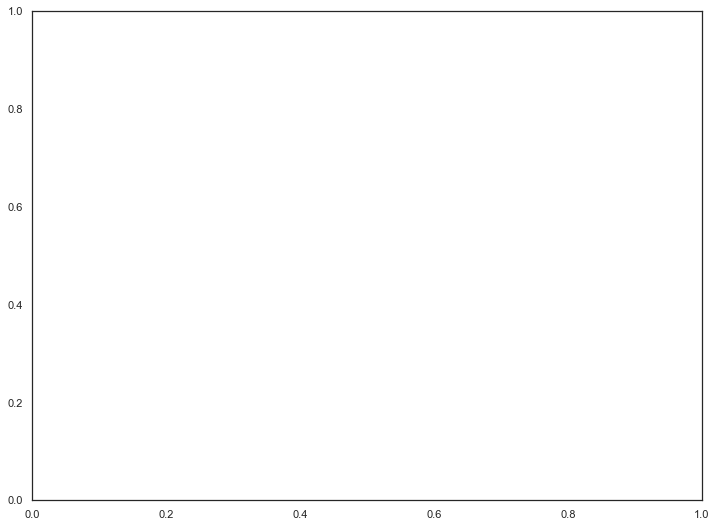

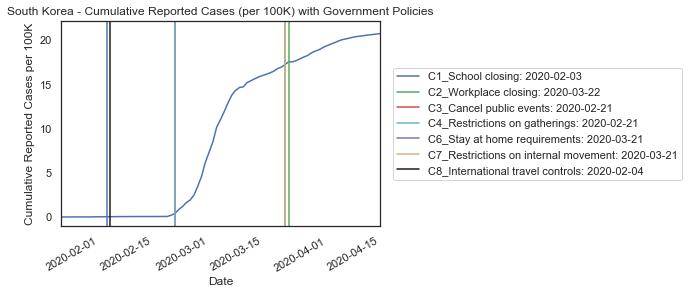

In [143]:
fig, ax = plt.subplots(figsize=(12,9))

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(korea_covid['CumulativeReportedCasesPer100K'])
colors = ['b', 'g', 'r', 'c', 'w', 'm', 'y', 'k']

for idx, i in enumerate(x_s):
    if korea_dict[labels[idx]]:
        plt.axvline(
            datetime.strptime(i, '%Y-%m-%d'),
            label= labels[idx] + ': ' + i,
            c=colors[idx]
        )

start = datetime.strptime('2020-02-03', '%Y-%m-%d')
end = datetime.strptime('2020-04-15', '%Y-%m-%d')
#ax.axvspan(start, datetime.strptime('2020-02-21', '%Y-%m-%d'), facecolor='#fa8072', alpha=0.5)
#ax.axvspan(datetime.strptime('2020-02-21', '%Y-%m-%d'), end, facecolor='#2ca02c', alpha=0.5)
ax.set_xlim(datetime.strptime('2020-01-22', '%Y-%m-%d'), datetime.strptime('2020-04-15', '%Y-%m-%d'))
#ax.set_ylim(-1, 250)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Reported Cases per 100K')
plt.title('South Korea - Cumulative Reported Cases (per 100K) with Government Policies')
ax.format_xdata = mdates.DateFormatter('%d %m')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
fig.autofmt_xdate()
    
#fig.savefig(saveloc)
plt.show()

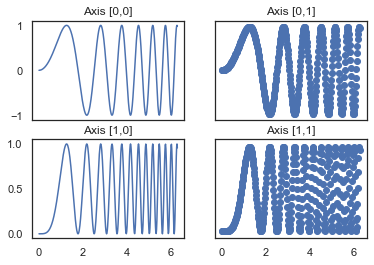

In [147]:
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

# Four axes, returned as a 2-d array
f, axarr = plt.subplots(2, 2)
axarr[0, 0].plot(x, y)
axarr[0, 0].set_title('Axis [0,0]')
axarr[0, 1].scatter(x, y)
axarr[0, 1].set_title('Axis [0,1]')
axarr[1, 0].plot(x, y ** 2)
axarr[1, 0].set_title('Axis [1,0]')
axarr[1, 1].scatter(x, y ** 2)
axarr[1, 1].set_title('Axis [1,1]')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

plt.show()

In [144]:
fig.savefig('korea.pdf', bbox_inches='tight')

In [ ]:
fig_map_cut.write_image(os.path.join(figures_path, "world_map_cut.pdf"))

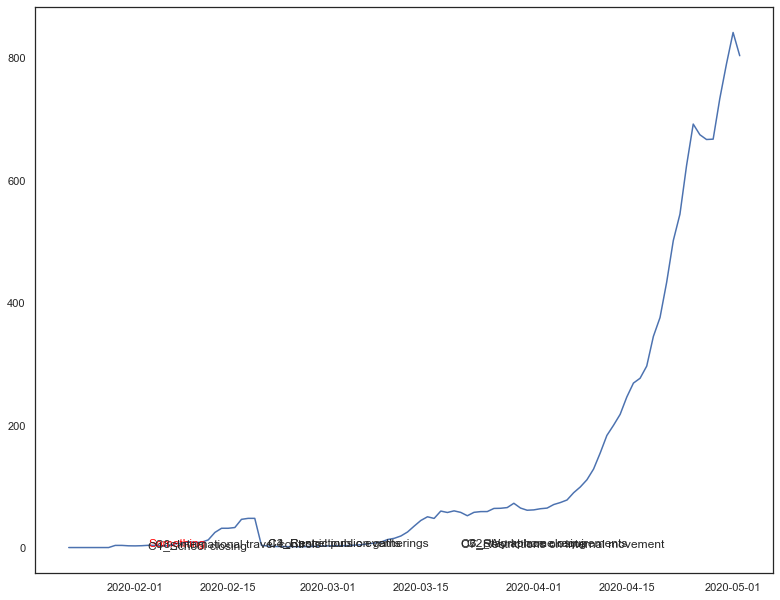

In [292]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

fig, ax = plt.subplots(figsize=(11,8.5))

ax.plot(korea_covid['DoublingTime'])

dates_list = []
for date in list(korea_dict.values()):
    if date:
        dates_list.append(datetime.strptime(date, '%Y-%m-%d').date())

dates = mdates.date2num(dates_list)
ax.text(dates[0], 1.5, 'Something', color='red')
#ax.text(0.25,ymax[i],id[i], transform=ax.transAxes, fontsize=15)
#ax.text(0.5, 0.8, 'Test', color='red', bbox=dict(facecolor='none', edgecolor='red'))

ax.annotate('C1_School closing', xy=(datetime.strptime('2020-02-03', '%Y-%m-%d'), 1.5),
           xycoords='data', xytext=(datetime.strptime('2020-02-03', '%Y-%m-%d'), 1.5), va='center')

ax.annotate('C2_Workplace closing', xy=(datetime.strptime('2020-03-22', '%Y-%m-%d'), 1.3),
           xycoords='data', xytext=(datetime.strptime('2020-03-22', '%Y-%m-%d'), 1.3))

ax.annotate('C3_Cancel public events', xy=(datetime.strptime('2020-02-21', '%Y-%m-%d'), 1.4),
           xycoords='data', xytext=(datetime.strptime('2020-02-21', '%Y-%m-%d'), 1.4))

ax.annotate('C4_Restrictions on gatherings', xy=(datetime.strptime('2020-02-21', '%Y-%m-%d'), 1.5),
           xycoords='data', xytext=(datetime.strptime('2020-02-21', '%Y-%m-%d'), 1.5))

ax.annotate('C6_Stay at home requirements', xy=(datetime.strptime('2020-03-21', '%Y-%m-%d'), 1.4),
           xycoords='data', xytext=(datetime.strptime('2020-03-21', '%Y-%m-%d'), 1.4))

ax.annotate('C7_Restrictions on internal movement', xy=(datetime.strptime('2020-03-21', '%Y-%m-%d'), 1.5),
           xycoords='data', xytext=(datetime.strptime('2020-03-21', '%Y-%m-%d'), 1.5))

ax.annotate('C8_International travel controls', xy=(datetime.strptime('2020-02-04', '%Y-%m-%d'), 1.3),
           xycoords='data', xytext=(datetime.strptime('2020-02-04', '%Y-%m-%d'), 1.3))

#plt.axvline(x=datetime.strptime('2020-02-03', '%Y-%m-%d'), color='r')
#x_line_annotation = datetime.strptime('2020-02-03', '%Y-%m-%d')
#x_text_annotation = datetime.strptime('2020-02-03', '%Y-%m-%d')
#ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
#ax.text(x=x_text_annotation, y=1.5, s='Holiday in US', alpha=0.7, color='#334f8d')

#set title and y label
#ax.set_title(title, fontsize=12)
#ax.set_ylabel(ylabel)
#ax.legend()
plt.tight_layout()
    
#fig.savefig(saveloc)
plt.show()

In [298]:
date_labels = list(korea_dict.keys())
date_values = []

for val in korea_dict.values():
    date_values.append(datetime.strptime(date, '%Y-%m-%d').date())
    
dates_dict = dict(zip(date_labels, date_values))

In [313]:
covid_df['ISO3Code'].unique()

array(['AFG', 'ALB', 'DZA', 'AND', 'AGO', 'AIA', 'ATG', 'ARG', 'ARM',
       'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR',
       'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES', 'BIH', 'BWA',
       'BRA', 'BRN', 'BGR', 'BFA', 'BDI', 'CPV', 'KHM', 'CMR', 'CAN',
       'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'COL', 'COM', 'COG', 'COD',
       'CRI', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'CIV', 'DNK', 'DJI',
       'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'SWZ',
       'ETH', 'FLK', 'FRO', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'GAB',
       'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GLP',
       'GTM', 'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'VAT', 'HND', 'HUN',
       'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA',
       'JAM', 'JPN', 'JOR', 'KAZ', 'KEN', 'KOR', 'XKX', 'KWT', 'KGZ',
       'LAO', 'LVA', 'LBN', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MDG',
       'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MTQ', 'MRT', 'MUS', 'MYT',
       'MEX', 'MDA',

In [316]:
selected = covid_df[(covid_df['ISO3Code'] == 'CHN') | 
         (covid_df['ISO3Code'] == 'FRA') |
         (covid_df['ISO3Code'] == 'GBR') |
         (covid_df['ISO3Code'] == 'ITA') |
         (covid_df['ISO3Code'] == 'KOR') |
         (covid_df['ISO3Code'] == 'USA')
        ]

In [325]:
fig = go.Figure()

#fig.add_trace(px.scatter(selected, x='Date', y='CumulativeReportedCasesPer100K'))

fig = px.scatter(selected, x="Date", y="CumulativeReportedCasesPer100K", facet_col="DisplayName", facet_col_wrap=3)
#fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
#fig.for_each_trace(lambda t: t.update(name=t.name.split("=")[1]))

fig.update_xaxes(range=['2020-01-22', '2020-04-15'])

fig.update_layout(
    #yaxis_title="y Axis Title",
    shapes=[
        dict(
            type='rect',
            xref='x',
            yref='paper',
            x0='2020-02-03',
            y0=0,
            x1='2020-04-25',
            y1=1,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    ]
)

fig.show()

---

In [133]:
responses_dict['KOR']

{}

Unify Country Names in Datasets:

In [ ]:
# Drop Columns other than Country.Region, iso3Code and Continent
# Create list of columns to keep
cols_to_keep_country = ['iso3Code','Country.Region']
cols_to_keep_continent = ['iso3Code','Continent']

# Drop all columns except those
iso_country_df = d['df_confirmed'].loc[:, cols_to_keep_country].drop_duplicates()
iso_continent_df = d['df_confirmed'].loc[:, cols_to_keep_continent].drop_duplicates()

# Create dictionaries of iso3Code and Country.Region
# Use set_index to set ID columns as the dataframe index.
country_dict = iso_country_df.set_index('iso3Code').to_dict()
continent_dict = iso_continent_df.set_index('iso3Code').to_dict()

In [ ]:
# Map continents dictionary to data frame
response_data_all['Country.Region'] = response_data_all['CountryCode'].map(country_dict['Country.Region'])
response_data_all['Continent'] = response_data_all['CountryCode'].map(continent_dict['Continent'])



In [ ]:
# Convert data to long-format
response_data_long = pd.melt(response_data_all, id_vars=['CountryName', 'Country.Region', 'CountryCode', 'Continent', 'Date'], var_name='indicator', value_name='codes')


In [ ]:
response_data_long.head()

In [ ]:
confirmed_iso_set = set(d['df_confirmed']['iso3Code'])
response_iso_set = set(response_data_all['CountryCode'])

print("Number of missing ISO Codes in Response Dataset:")
print(len(confirmed_iso_set - response_iso_set))
print("Missing ISO Codes in Response Dataset:")
print(confirmed_iso_set - response_iso_set)

### TODO: Check & fix missing CountryCodes

## Create Simple Dataframe with Date Ranges for Responses

In [ ]:
# Function
# Select indicator
# country | code | indicator | start_date | end_date

def create_simple_df(country, indicator, df):
    df = df[df['CountryName'] == country]
    df = df[df['indicator'] == indicator]
    df = df[df.apply(lambda x: x['codes'] > 0 & pd.isnull(x['codes']), axis=1)]
    
    country_code = str(df['CountryCode'].unique()).strip("['']")
    start_date = df['Date'].min()
    end_date = df['Date'].max()
    return country, country_code, indicator, start_date, end_date

In [ ]:
countries_list = response_data_long['CountryName'].unique()
indicators_list = response_data_long['indicator'].unique()

response_list = []

for country in countries_list:
    for indicator in indicators_list:
        response_list.append(create_simple_df(country, indicator, response_data_long))

In [ ]:
response_range_df = pd.DataFrame(response_list, columns=['CountryName', 'CountryCode', 'Indicator', 'Start_Date', 'End_Date'])

In [ ]:
response_range_df['Duration'] = response_range_df['End_Date'] - response_range_df['Start_Date']

In [ ]:
# From beginning of data collection
day_zero = response_data_all['Date'].min()

response_range_df['days_from_start'] = (response_range_df['Start_Date'] - day_zero).dt.days.tolist()

In [ ]:
response_range_df['Duration_Days'] = (response_range_df['End_Date'] - response_range_df['Start_Date']).dt.days.tolist()

In [ ]:
# Print basic information about dataset
response_range_df.info()

In [ ]:
response_range_df.head()

## Apply selections to display

In [ ]:
selected_indicator = 'S6_Restrictions on internal movement'

selected_region = ['Europe']

In [ ]:
response_data_long.columns

In [ ]:
# Define data frame with selected optons
selected_df = response_data_long[response_data_long['Continent'].isin(selected_region)]
selected_df = selected_df[response_data_long['indicator'] == selected_indicator]

selected_df['Date'] = selected_df['Date'].dt.strftime('%Y-%m-%d')
#selected_df['codes'].fillna(0, inplace=True)

In [ ]:
selected_df.info()

In [ ]:
selected_df['Date'].min()

In [ ]:
import os

if not os.path.exists("images"):
    os.mkdir("images")

In [ ]:
colorscale = [
    [0, 'rgba(0,0,0,0)'], 
    [0.3333, 'rgb(254,153,41)'],
    [1, 'rgb(108,36,36)'],
    #[1, 'rgba(0,0,0,0)']
]

start_date = selected_df['Date'].min()
end_date = selected_df['Date'].max()

# plotly express
fig = px.bar(selected_df, x="Date", y="Country.Region", color='codes', orientation='h',
             hover_data=["Date"],
             height=800,
             #marker={'color': color},
             #color_continuous_scale=colorscale,
             color_continuous_scale=colorscale, #['rgba(0,0,0,0)', 'teal'],
             title='S6_Restrictions on internal movement in selected countries',
             #template='plotly_white',
             #range_x=[start_date, end_date]
            )

#fig.update_traces(showlegend=False)
#fig.update(layout_coloraxis_showscale=False)
#fig.update_layout(yaxis=dict(title=''),
#                  xaxis=dict(title='Date',
                             #zeroline=False,gridwidth=2,
#                              gridcolor='grey',
                              #tickmode= 'array',
                              #tickmode= 'linear',
                              #tick0= response_data_long['Date'].min(),
                              #dtick=86400000.0 * 14,#2,
                              #tickvals=dfm2['Date'],
                              #tickvals= date_list,
                             #tickvals=[dfm2['Date'].min(), dfm2['Date'].max()],
                             #ticktext = date_list,
                             #type='date'
#                            )
#                 )
#fig.update_layout(xaxis_range=[datetime(2013, 10, 17),
#                               datetime(2013, 11, 20)])

fig.update_layout(yaxis=dict(title=''),
                  xaxis=dict(title='Date',
                            type='date')
                 )

fig.show()

#fig.write_image("images/fig3.pdf")

In [ ]:
# Define data frame with selected optons
selected_df = response_df[response_df['Continent'].isin(selected_region)]
selected_df = selected_df[selected_df['Indicator'] == selected_indicator]

In [ ]:
#activated = [True, False, False, True, False, True]
#alarm_number = [1, 2, 3, 3, 1, 2]
country = selected_df['CountryName']
#start = [0, 0, 1, 2, 1, 3]
start_date = selected_df['days_zero_start']
#duration = [1, 3, 1, 3, 2, 2]
duration = selected_df['Duration_Days']
#duration = start_date + timedelta(date_diff)

fig = go.Figure()

bar = fig.add_bar(y=country,
                  x=duration,
                  base=start_date,
                  #marker={'color': ['green' if active else 'red' for active in activated]},
                  marker={'color': 'rgba(246, 78, 139, 0.6)'},
                  orientation='h')
fig.layout.barmode = 'stack'

#bar = fig.add_bar(y=alarm_number,
#                  x=duration,
#                  base=start,
#                  #marker={'color': ['green' if active else 'red' for active in activated]},
#                  marker={'color': 'rgba(246, 78, 139, 0.6)'},
#                  orientation='h')
#fig.layout.barmode = 'stack'
fig.update_layout(xaxis={
    'type':'date',
    #'range': [response_data_all['Date'].min(), response_data_all['Date'].max()]
})
# [datetime(response_data_all['Date'].min()),datetime(response_data_all['Date'].max())]
fig.show()

In [ ]:

df_for_plot = response_df[(response_df['Continent'].isin(selected_region) ) & (response_df['Indicator'] == selected_indicator)].drop(['CountryCode', 'Indicator'], axis=1)


In [ ]:
#dfm2['Date'] = pd.to_datetime(dfm2['Date'])#.dt.date

In [ ]:
dfm2.head()

In [ ]:
type(dfm2['Date'].iloc[0])

In [ ]:
date_list = dfm2['Date'].values.tolist()
type(date_list)
#date_list

In [ ]:
# data
np.random.seed(1)
cols=list('ABCDE')
df = pd.DataFrame(np.random.randint(0,2,size=(5, len(cols))), columns=cols)
drng=pd.date_range(pd.datetime(2020, 1, 1).strftime('%Y-%m-%d'), periods=df.shape[0]).tolist()
df['date']=[d.strftime('%Y-%m-%d') for d in drng]
dfm=pd.melt(df, id_vars=['date'], value_vars=df.columns[:-1])

In [ ]:
cols
df

In [ ]:
type(df['date'][0])

In [ ]:
date_rng = pd.date_range(start=resp['Date'].min(), end=resp['Date'].max())

In [ ]:
type(date_rng[0])

In [ ]:
resp['S1_School closing'].plot()

In [ ]:
# Load the example car crash dataset
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

In [ ]:
crashes.head()

In [ ]:
selected_df.head()

In [ ]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="total", y="abbrev", data=crashes,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="alcohol", y="abbrev", data=crashes,
            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)